## Set-up environment

Let's start by installing 🤗 Transformers and [EasyOCR](https://github.com/JaidedAI/EasyOCR) (an open-source OCR engine). Google Colab already comes with Transformers pre-installed.

## Load model

Next, we load a Table Transformer pre-trained for table detection. We use the "no_timm" version here to load the checkpoint with a Transformers-native backbone.

In [1]:
from transformers import AutoModelForObjectDetection

model = AutoModelForObjectDetection.from_pretrained("microsoft/table-transformer-detection", revision="no_timm")

c:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model.config.id2label

{0: 'table', 1: 'table rotated'}

We move the model to a GPU if it's available (predictions will be faster).

In [3]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(device)

cuda


## Load image

Next, we can load a PDF image.

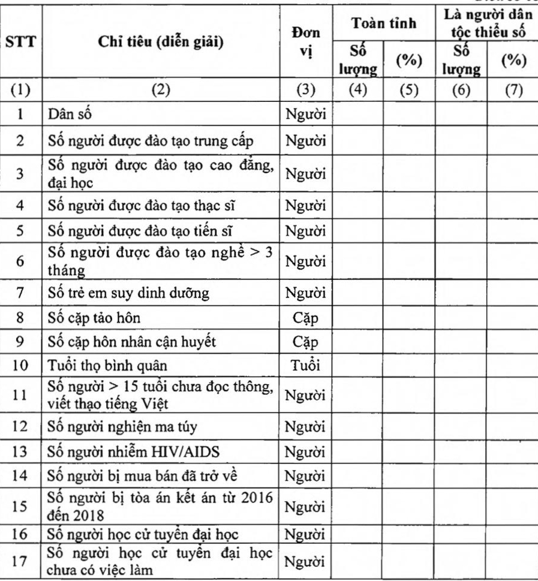

In [4]:
from PIL import Image
from huggingface_hub import hf_hub_download

# let's load an example image
#file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="image.png")
file_path =r'D:\Private\Project\kaggle\VietOCR\Recognition-Table-with-Table_Transformer-and-vietOCR\images\edge.png'
image = Image.open(file_path).convert("RGB")
# let's display it a bit smaller
width, height = image.size
display(image.resize((int(0.6*width), (int(0.6*height)))))

## Prepare image for the model

Preparing the image for the model can be done as follows:

In [5]:
from torchvision import transforms

class MaxResize(object):
    def __init__(self, max_size=800):
        self.max_size = max_size

    def __call__(self, image):
        width, height = image.size
        current_max_size = max(width, height)
        scale = self.max_size / current_max_size
        resized_image = image.resize((int(round(scale*width)), int(round(scale*height))))

        return resized_image

detection_transform = transforms.Compose([
    MaxResize(800),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
pixel_values = detection_transform(image).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 800, 741])


## Forward pass

Next, we forward the pixel values through the model. The model outputs logits of shape (batch_size, num_queries, num_labels + 1). The +1 is for the "no object" class.

In [7]:
import torch

with torch.no_grad():
  outputs = model(pixel_values)

In [8]:
outputs.logits.shape

torch.Size([1, 15, 3])

## Postprocessing

Next, we take the prediction that has an actual class (i.e. not "no object").

In [9]:
def adjust_bbox(bbox, img_size, margin=0.02):
    """
    Điều chỉnh bounding box bằng cách thêm khoảng lề.
    bbox: (x1, y1, x2, y2) - tọa độ của bounding box
    img_size: kích thước của hình ảnh (width, height)
    margin: tỷ lệ phần trăm của khoảng lề
    """
    x1, y1, x2, y2 = bbox
    img_w, img_h = img_size

    width = x2 - x1
    height = y2 - y1

    # Tính toán khoảng lề
    dx = width * margin
    dy = height * margin

    # Điều chỉnh tọa độ
    x1 = max(0, x1 - dx)
    y1 = max(0, y1 - dy)
    x2 = min(img_w, x2 + dx)
    y2 = min(img_h, y2 + dy)

    return [x1, y1, x2, y2]


In [10]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(-1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h), (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)


def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


# update id2label to include "no object"
id2label = model.config.id2label
id2label[len(model.config.id2label)] = "no object"


def outputs_to_objects(outputs, img_size, id2label):
    m = outputs.logits.softmax(-1).max(-1)
    pred_labels = list(m.indices.detach().cpu().numpy())[0]
    pred_scores = list(m.values.detach().cpu().numpy())[0]
    pred_bboxes = outputs['pred_boxes'].detach().cpu()[0]
    pred_bboxes = [elem.tolist() for elem in rescale_bboxes(pred_bboxes, img_size)]

    objects = []
    for label, score, bbox in zip(pred_labels, pred_scores, pred_bboxes):
        class_label = id2label[int(label)]
        if not class_label == 'no object':
            objects.append({'label': class_label, 'score': float(score),
                            'bbox': [float(elem) for elem in bbox]})

    return objects

In [11]:
objects = outputs_to_objects(outputs, image.size, id2label)

In [12]:
print(objects)

[{'label': 'table', 'score': 0.9998683929443359, 'bbox': [7.266959190368652, 8.230185508728027, 887.1616821289062, 963.8909912109375]}]


## Visualize

We can visualize the detection on the image.

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch

def fig2img(fig):
    """Convert a Matplotlib figure to a PIL Image and return it"""
    import io
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img


def visualize_detected_tables(img, det_tables, out_path=None):
    plt.imshow(img, interpolation="lanczos")
    fig = plt.gcf()
    fig.set_size_inches(20, 20)
    ax = plt.gca()

    img_size = img.size

    for det_table in det_tables:
        bbox = det_table['bbox']
        bbox = adjust_bbox(bbox, img_size)

        if det_table['label'] == 'table':
            facecolor = (1, 0, 0.45)
            edgecolor = (1, 0, 0.45)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        elif det_table['label'] == 'table rotated':
            facecolor = (0.95, 0.6, 0.1)
            edgecolor = (0.95, 0.6, 0.1)
            alpha = 0.3
            linewidth = 2
            hatch='//////'
        else:
            continue

        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor='none',facecolor=facecolor, alpha=0.1)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=linewidth,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', alpha=alpha)
        ax.add_patch(rect)
        rect = patches.Rectangle(bbox[:2], bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=0,
                                    edgecolor=edgecolor,facecolor='none',linestyle='-', hatch=hatch, alpha=0.2)
        ax.add_patch(rect)

    plt.xticks([], [])
    plt.yticks([], [])

    legend_elements = [Patch(facecolor=(1, 0, 0.45), edgecolor=(1, 0, 0.45),
                                label='Table', hatch='//////', alpha=0.3),
                        Patch(facecolor=(0.95, 0.6, 0.1), edgecolor=(0.95, 0.6, 0.1),
                                label='Table (rotated)', hatch='//////', alpha=0.3)]
    plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.02), loc='upper center', borderaxespad=0,
                    fontsize=10, ncol=2)
    plt.gcf().set_size_inches(10, 10)
    plt.axis('off')

    if out_path is not None:
      plt.savefig(out_path, bbox_inches='tight', dpi=150)

    return fig

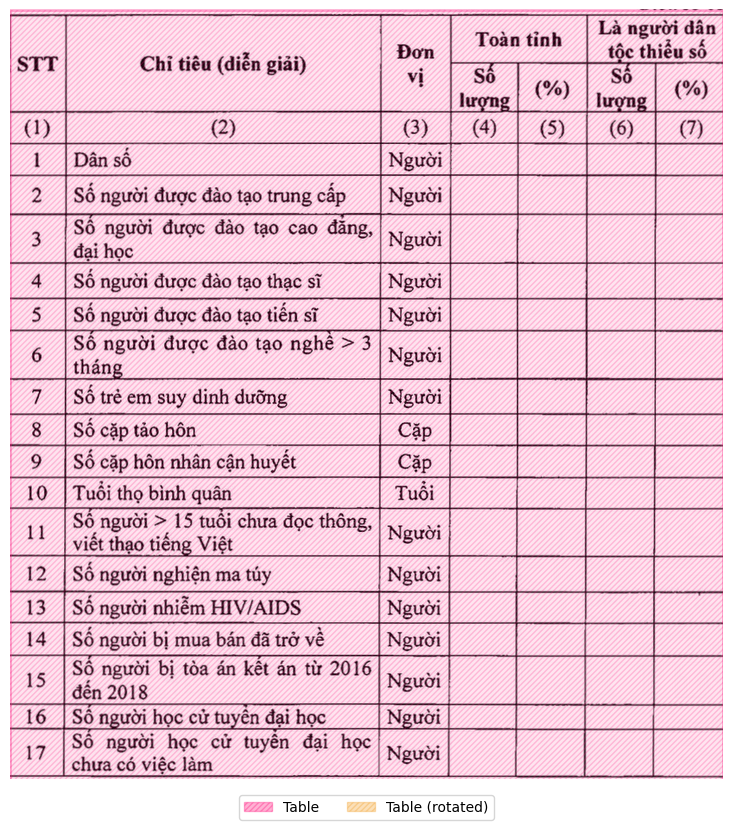

In [14]:
fig = visualize_detected_tables(image, objects)

In [15]:
visualized_image = fig2img(fig)

## Crop table

Next, we crop the table out of the image. For that, the TATR authors employ some padding to make sure the borders of the table are included.

In [16]:
def objects_to_crops(img, tokens, objects, class_thresholds, padding=10):
    """
    Process the bounding boxes produced by the table detection model into
    cropped table images and cropped tokens.
    """

    table_crops = []
     # Kích thước của ảnh gốc
    img_w, img_h = img.size
    for obj in objects:
        if obj['score'] < class_thresholds[obj['label']]:
            continue

        cropped_table = {}

        bbox = obj['bbox']
        bbox = [bbox[0] - padding, bbox[1] - padding, bbox[2] + padding, bbox[3] + padding]

        bbox = [
            max(0, bbox[0]),
            max(0, bbox[1]),
            min(img_w, bbox[2]),
            min(img_h, bbox[3])
        ]

        cropped_img = img.crop(bbox)

        table_tokens = [token for token in tokens if iob(token['bbox'], bbox) >= 0.5]
        for token in table_tokens:
            token['bbox'] = [
                token['bbox'][0]-bbox[0],
                token['bbox'][1]-bbox[1],
                token['bbox'][2]-bbox[0],
                token['bbox'][3]-bbox[1]]

        # If table is predicted to be rotated, rotate cropped image and tokens/words:
        if obj['label'] == 'table rotated':
            cropped_img = cropped_img.rotate(270, expand=True)
            for token in table_tokens:
                bbox = token['bbox']
                bbox = [cropped_img.size[0]-bbox[3]-1,
                        bbox[0],
                        cropped_img.size[0]-bbox[1]-1,
                        bbox[2]]
                token['bbox'] = bbox

        cropped_table['image'] = cropped_img
        cropped_table['tokens'] = table_tokens

        table_crops.append(cropped_table)

    return table_crops

In [17]:
objects

[{'label': 'table',
  'score': 0.9998683929443359,
  'bbox': [7.266959190368652,
   8.230185508728027,
   887.1616821289062,
   963.8909912109375]}]

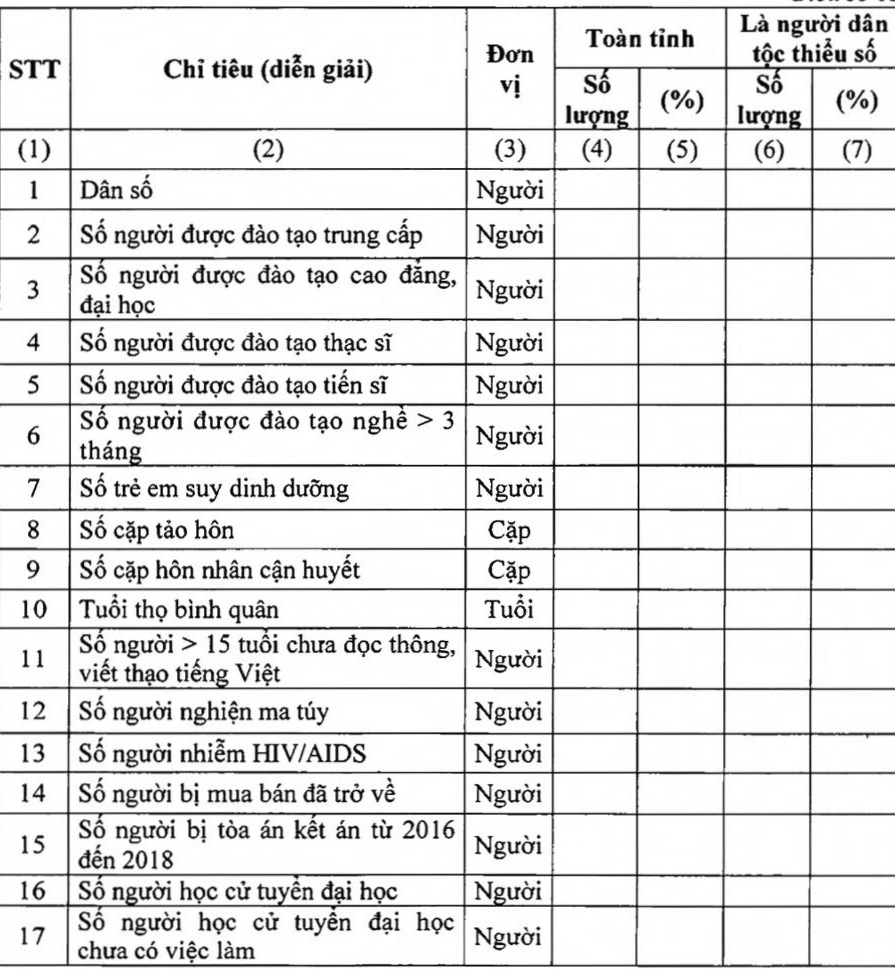

In [18]:
tokens = []
detection_class_thresholds = {
    "table": 0.5,
    "table rotated": 0.5,
    "no object": 10
}
crop_padding = 8
tables_crops = objects_to_crops(image, tokens, objects, detection_class_thresholds, padding=crop_padding)
#tables_crops = objects_to_crops(image, tokens, objects, detection_class_thresholds, padding=0)
cropped_table = tables_crops[0]['image'].convert("RGB")
cropped_table

In [19]:
cropped_table.save("table.jpg")

## Load structure recognition model

Next, we load a Table Transformer pre-trained for table structure recognition.

In [20]:
from transformers import TableTransformerForObjectDetection

# new v1.1 checkpoints require no timm anymore
structure_model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-structure-recognition-v1.1-all")
structure_model.to(device)
print(structure_model)

TableTransformerForObjectDetection(
  (model): TableTransformerModel(
    (backbone): TableTransformerConvModel(
      (conv_encoder): TableTransformerConvEncoder(
        (model): ResNetBackbone(
          (embedder): ResNetEmbeddings(
            (embedder): ResNetConvLayer(
              (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
              (normalization): TableTransformerFrozenBatchNorm2d()
              (activation): ReLU()
            )
            (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          )
          (encoder): ResNetEncoder(
            (stages): ModuleList(
              (0): ResNetStage(
                (layers): Sequential(
                  (0): ResNetBasicLayer(
                    (shortcut): Identity()
                    (layer): Sequential(
                      (0): ResNetConvLayer(
                        (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(

We prepare the cropped table image for the model, and perform a forward pass.

In [21]:
structure_transform = transforms.Compose([
    MaxResize(1000),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [22]:
pixel_values = structure_transform(cropped_table).unsqueeze(0)
pixel_values = pixel_values.to(device)
print(pixel_values.shape)

torch.Size([1, 3, 1000, 924])


In [23]:
# forward pass
with torch.no_grad():
  outputs = structure_model(pixel_values)

Next, we get the predicted detections.

In [24]:
# update id2label to include "no object"
structure_id2label = structure_model.config.id2label
structure_id2label[len(structure_id2label)] = "no object"

cells = outputs_to_objects(outputs, cropped_table.size, structure_id2label)
print(cells)

[{'label': 'table column', 'score': 0.9999727010726929, 'bbox': [65.74944305419922, 6.485464572906494, 464.63165283203125, 962.003662109375]}, {'label': 'table row', 'score': 0.9997348189353943, 'bbox': [5.778162479400635, 166.97230529785156, 889.12255859375, 207.51536560058594]}, {'label': 'table spanning cell', 'score': 0.9944773316383362, 'bbox': [467.40869140625, 6.362828731536865, 557.353515625, 127.33953857421875]}, {'label': 'table spanning cell', 'score': 0.9980790615081787, 'bbox': [5.706101894378662, 6.261165618896484, 67.9817123413086, 127.71233367919922]}, {'label': 'table column', 'score': 0.9999169111251831, 'bbox': [721.051025390625, 6.892679691314697, 820.242431640625, 962.3473510742188]}, {'label': 'table spanning cell', 'score': 0.9983550906181335, 'bbox': [68.19285583496094, 6.270413875579834, 467.8779602050781, 128.1136474609375]}, {'label': 'table column header', 'score': 0.9988642930984497, 'bbox': [5.8561811447143555, 6.085079193115234, 889.1190795898438, 128.392

## Visualize cells

We can visualize all recognized cells using PIL's ImageDraw module.

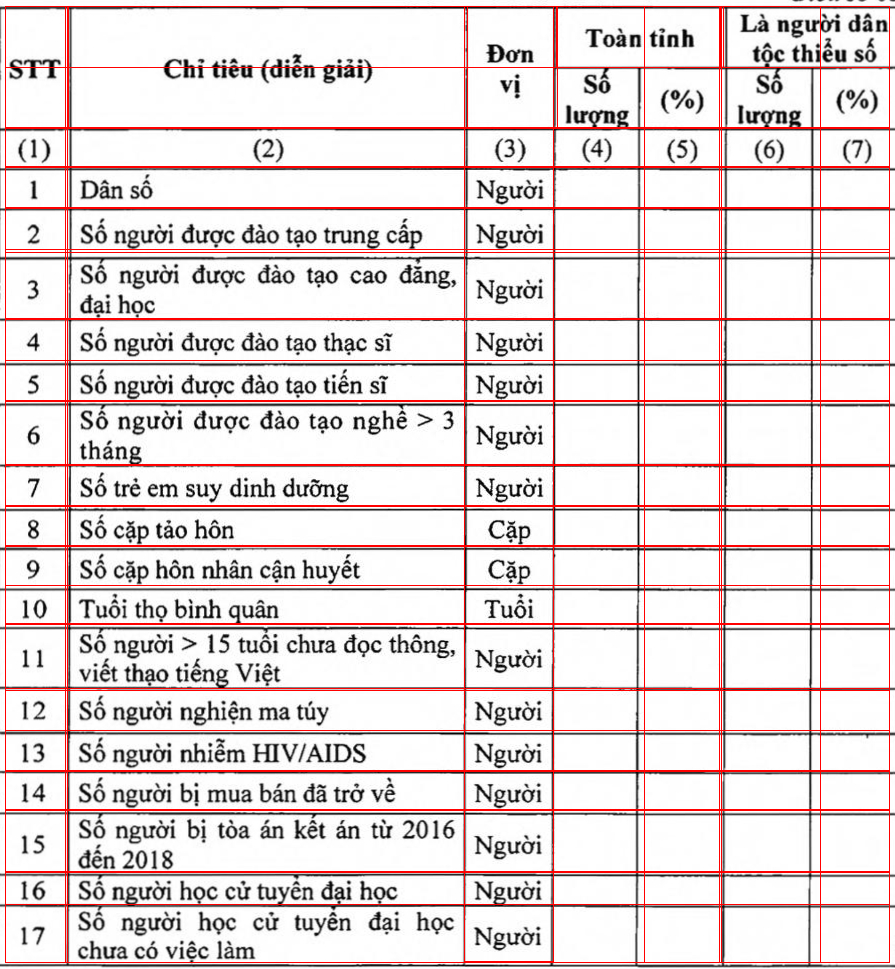

In [25]:
from PIL import ImageDraw

cropped_table_visualized = cropped_table.copy()
draw = ImageDraw.Draw(cropped_table_visualized)

for cell in cells:
    draw.rectangle(cell["bbox"], outline="red")

cropped_table_visualized

An alternative way of plotting is to select one class to visualize, like "table row":

In [26]:
def plot_results(cells, class_to_visualize):
    if class_to_visualize not in structure_model.config.id2label.values():
      raise ValueError("Class should be one of the available classes")

    plt.figure(figsize=(16,10))
    plt.imshow(cropped_table)
    ax = plt.gca()

    for cell in cells:
        score = cell["score"]
        bbox = cell["bbox"]
        label = cell["label"]

        if label == class_to_visualize:
          xmin, ymin, xmax, ymax = tuple(bbox)

          ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=3))
          text = f'{cell["label"]}: {score:0.2f}'
          ax.text(xmin, ymin, text, fontsize=15,
                  bbox=dict(facecolor='yellow', alpha=0.5))
          plt.axis('off')

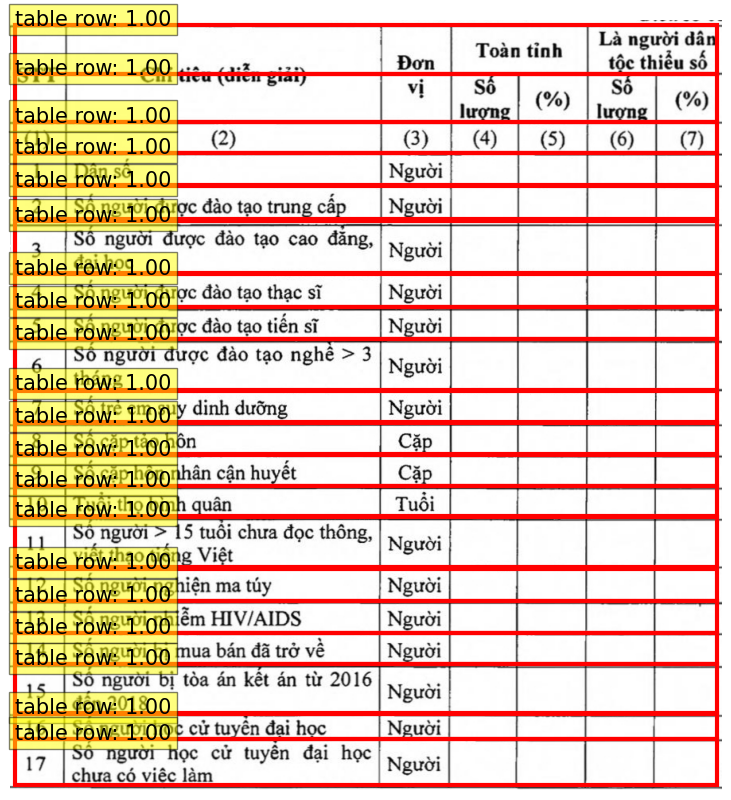

In [27]:
plot_results(cells, class_to_visualize="table row")

## Apply OCR row by row

First, we get the coordinates of the individual cells, row by row, by looking at the intersection of the table rows and columns (thanks ChatGPT!).

Next, we apply OCR on each individual cell, row-by-row.

Note that this makes some assumptions about the structure of the table: it assumes that the table has a rectangular, flat structure, containing a column header. One would need to update this for more complex table structures, potentially fine-tuning the detection and/or structure recognition model to be able to detect other layouts. Typically 50 labeled examples suffice for fine-tuning, but the more data you have, the better.

Alternatively, one could also do OCR column by column, etc.

In [28]:
def get_cell_coordinates_by_row(table_data):
    # Extract rows and columns
    rows = [entry for entry in table_data if entry['label'] == 'table row']
    columns = [entry for entry in table_data if entry['label'] == 'table column']

    # Sort rows and columns by their Y and X coordinates, respectively
    rows.sort(key=lambda x: x['bbox'][1])
    columns.sort(key=lambda x: x['bbox'][0])

    # Function to find cell coordinates
    def find_cell_coordinates(row, column):
        cell_bbox = [column['bbox'][0], row['bbox'][1], column['bbox'][2], row['bbox'][3]]
        return cell_bbox

    # Generate cell coordinates and count cells in each row
    cell_coordinates = []

    for row in rows:
        row_cells = []
        for column in columns:
            cell_bbox = find_cell_coordinates(row, column)
            row_cells.append({'column': column['bbox'], 'cell': cell_bbox})

        # Sort cells in the row by X coordinate
        row_cells.sort(key=lambda x: x['column'][0])

        # Append row information to cell_coordinates
        cell_coordinates.append({'row': row['bbox'], 'cells': row_cells, 'cell_count': len(row_cells)})

    # Sort rows from top to bottom
    cell_coordinates.sort(key=lambda x: x['row'][1])

    return cell_coordinates

cell_coordinates = get_cell_coordinates_by_row(cells)

In [29]:
len(cell_coordinates) ## cell row

20

In [30]:
len(cell_coordinates[0]["cells"]) ## column

7

In [31]:
for row in cell_coordinates:
  print(row["cells"])

[{'column': [5.595485210418701, 6.665463924407959, 67.37847900390625, 962.0106201171875], 'cell': [5.595485210418701, 6.132342338562012, 67.37847900390625, 67.79429626464844]}, {'column': [65.74944305419922, 6.485464572906494, 464.63165283203125, 962.003662109375], 'cell': [65.74944305419922, 6.132342338562012, 464.63165283203125, 67.79429626464844]}, {'column': [464.4349060058594, 6.378469944000244, 553.1383666992188, 961.9154052734375], 'cell': [464.4349060058594, 6.132342338562012, 553.1383666992188, 67.79429626464844]}, {'column': [553.539306640625, 6.779129505157471, 644.4238891601562, 962.1328125], 'cell': [553.539306640625, 6.132342338562012, 644.4238891601562, 67.79429626464844]}, {'column': [644.3418579101562, 6.768791198730469, 719.6172485351562, 962.0408935546875], 'cell': [644.3418579101562, 6.132342338562012, 719.6172485351562, 67.79429626464844]}, {'column': [721.051025390625, 6.892679691314697, 820.242431640625, 962.3473510742188], 'cell': [721.051025390625, 6.1323423385

In [32]:
import numpy as np
import csv
import easyocr
from tqdm.auto import tqdm

reader = easyocr.Reader(['en']) # this needs to run only once to load the model into memory

def apply_ocr(cell_coordinates):
    # let's OCR row by row
    data = dict()
    max_num_columns = 0
    for idx, row in enumerate(tqdm(cell_coordinates)):
      row_text = []
      for cell in row["cells"]:
        # crop cell out of image
        cell_image = np.array(cropped_table.crop(cell["cell"]))
        # apply OCR
        result = reader.readtext(np.array(cell_image))
        if len(result) > 0:
          # print([x[1] for x in list(result)])
          text = " ".join([x[1] for x in result])
          row_text.append(text)

      if len(row_text) > max_num_columns:
          max_num_columns = len(row_text)

      data[idx] = row_text

    print("Max number of columns:", max_num_columns)

    # pad rows which don't have max_num_columns elements
    # to make sure all rows have the same number of columns
    for row, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
          row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
        data[row] = row_data

    return data

data_easy_ocr = apply_ocr(cell_coordinates)

for row, row_data in data_easy_ocr.items():
    print(row_data)

100%|██████████| 20/20 [00:09<00:00,  2.12it/s]

Max number of columns: 6
['Don', 'Toan', 'tinh', 'La ngu toc thi', 'oi dan eu s6', '']
['D 1', 'CI ticu (uieh 3441)', 'So luong', '(%)', 'So Iuong', '(%)']
['(3)', '(5)', '', '', '', '']
['Dan so', 'Nguoi', '', '', '', '']
['2', 'So dugc dao tao trung cap nguoi', 'Nguoi', '', '', '']
['3', 'So duoc dao tao cao dai hoc ngudi dang;', 'Ngudi', '', '', '']
['So dugc dao tao thac si nguoi', 'Nguoi', '', '', '', '']
['5', 'So dugc dao tao tien si nguoi', 'Nguoi', '', '', '']
['6', 'S8 ngudi duac dao tao 7 3 thang nghe', 'Ngudi', '', '', '']
['S8 tre em suy dinh duong', 'Nguoi', '', '', '', '']
['8', 'So cap tao hon', 'Cap', '', '', '']
['S8 cap hon nhan can huyet', 'Cap', '', '', '', '']
['10', 'Tudi tho binh quan', 'Tudi', '', '', '']
['11', 'So >15 tudi chua doc viet thao tieng Viet nguoi thong;', 'Nguoi', '', '', '']
['12', 'S6 nghien ma tuy nguoi', 'Nguoi', '', '', '']
['13', 'S6 nhiem HIVIAIDS nguoi', 'Nguoi', '', '', '']
['14', 'S6 bj mua ban da tro ve nguoi', 'Nguoi', '', '', '']
['15

### Nhận diện text với VietOCR thay vì EasyOCR

In [33]:
# from paddleocr import PaddleOCR, draw_ocr

# ocr = PaddleOCR(use_angle_cls=True, lang='en')


Error: Can not import paddle core while this file exists: c:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\paddle\base\libpaddle.pyd


ImportError: generic_type: type "_gpuDeviceProperties" is already registered!

In [34]:
import numpy as np
import csv
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg
from PIL import Image
from tqdm.auto import tqdm

cfg = Cfg.load_config_from_name('vgg_transformer')  # download from internet, should use local config
predictor = Predictor(cfg)

def apply_ocr(cell_coordinates):
    data = dict()
    max_num_columns = 0

    for idx, row in enumerate(tqdm(cell_coordinates)):
        row_text = []
        for cell in row["cells"]:
            # Crop cell ra khỏi hình ảnh
            cell_image = cropped_table.crop(cell["cell"])
            cell_image = np.array(cell_image)
            cell_image_pil = Image.fromarray(cell_image)

            # Áp dụng OCR
            result = predictor.predict(cell_image_pil)

            if result:
                text = "".join(result)
                row_text.append(text)

        if len(row_text) > max_num_columns:
            max_num_columns = len(row_text)

        data[idx] = row_text

    print("Max number of columns:", max_num_columns)

    # Padding các hàng không có đủ số lượng cột
    for row, row_data in data.copy().items():
        if len(row_data) != max_num_columns:
            row_data = row_data + ["" for _ in range(max_num_columns - len(row_data))]
        data[row] = row_data

    return data

# Giả định rằng bạn đã có biến cell_coordinates và cropped_table
data_viet_ocr = apply_ocr(cell_coordinates)

for row, row_data in data_viet_ocr.items():
    print(row_data)


c:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Model weight C:\Users\Windows\AppData\Local\Temp\vgg_transformer.pth exsits. Ignore download!


100%|██████████| 20/20 [00:23<00:00,  1.16s/it]

Max number of columns: 7
['11', 'Constructionalists', 'Đơn', 'Toàn', 'tỉnh', 'Làngu', 'ời dận']
['511', '03600000000019', 'vị', 'lượng', '(%)', 'lược', '(%)']
['(1)', '(2)', '(3)', '(4)', '(5)', '(6)', '(7)']
['1', 'Dân số', 'Người', 'Contermines', 'Star', 'Cont', 'Star']
['2', 'Số người được đào tạo trung cấp', 'Người', 'Star', 'Stat', 'Bar', 'Star']
['3', 'số người được đào tạo cao đảng,', 'Người', '03', '1', '03', '1']
['4', 'Số người được đào tạo thạc sĩ', 'Người', 'Star', 'Stat', 'Barry', 'Star']
['5', 'Số người được đào tạo tiến sĩ', 'Người', 'ST', 'Star', 'Cont', 'Star']
['6', 'Số người được đào tạo nghề 5 ? 3', 'Người', '03', '1', '03', '1']
['7', 'Số trẻ em suy dinh dưỡng', 'Người', 'Star', '19', 'Cont', 'Stat']
['8', 'Số cặp tảo hôn', 'Cặp', 'ST', 'Star', 'Barry', 'Star']
['9', 'Số cặp hôn nhân cận huyết', 'Cặp', 'ST', 'Stark', 'CONT', 'Star']
['10', 'Tuổi thọ bình quân', 'Tuổi', 'Cont', 'Start', 'Contermines', 'Star']
['11', 'Số người 315 tuổi chưa dọc thông,', 'Người', '1',

## Save as CSV

We end up with a CSV file containing the data.

In [ ]:
import numpy as np
from paddleocr import PaddleOCR
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg
from PIL import Image

# Khởi tạo PaddleOCR và VietOCR
ocr = PaddleOCR(lang='vi')
cfg = Cfg.load_config_from_name('vgg_transformer')
predictor = Predictor(cfg)

# Đường dẫn ảnh
img_path = r'D:\Private\Project\kaggle\VietOCR\Recognition-Table-with-Table_Transformer-and-vietOCR\images\edge.png'
image = Image.open(img_path).convert('RGB')

# Nhận diện văn bản bằng PaddleOCR
result = ocr.ocr(img_path, cls=True)


with open('file.txt','w',encoding = 'utf-8') as file:
    for i, line in enumerate(result):
        for elements in line:
            
            box = elements[0]

            x_min = int(min(point[0] for point in box))
            y_min = int(min(point[1] for point in box))
            x_max = int(max(point[0] for point in box))
            y_max = int(max(point[1] for point in box))

            cropped_box = image.crop((x_min, y_min, x_max, y_max))

            cropped_box_np = np.array(cropped_box)

            result_text = predictor.predict(Image.fromarray(cropped_box_np))

            print(f"Box {i + 1}:")
            print(f"- Toạ độ: {box}")
            print(f"- Nội dung (VietOCR): {result_text}\n")
            file.write(f"Box {i + 1}: \n")
            file.write(f"- Toạ độ: {box}: \n")
            file.write(f"- Nội dung (VietOCR):{result_text} \n")
            
            
            




[2025/03/14 02:57:42] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\Windows/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\Windows/.paddleocr/whl\\rec\\latin\\latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3,

In [35]:
import numpy as np
from paddleocr import PaddleOCR
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg
from PIL import Image

# Khởi tạo PaddleOCR và VietOCR
ocr = PaddleOCR(lang='vi')
cfg = Cfg.load_config_from_name('vgg_transformer')
predictor = Predictor(cfg)

# Đường dẫn ảnh
img_path = r'D:\Private\Project\kaggle\VietOCR\Recognition-Table-with-Table_Transformer-and-vietOCR\images\edge.png'
image = Image.open(img_path).convert('RGB')

# Nhận diện văn bản bằng PaddleOCR
result = ocr.ocr(img_path, cls=True)

# Ghi kết quả vào file
with open('file.txt', 'w', encoding='utf-8') as file:
    box_count = 0
    
    for line in result:
        for elements in line:
            box_count += 1
            
            box = elements[0]
            
            # Tính toạ độ của box
            x_min = int(min(point[0] for point in box))
            y_min = int(min(point[1] for point in box))
            x_max = int(max(point[0] for point in box))
            y_max = int(max(point[1] for point in box))

            # Cắt từng ô chữ ra ảnh riêng
            cropped_box = image.crop((x_min, y_min, x_max, y_max))

            # Chuyển ảnh về numpy array để xử lý với VietOCR
            cropped_box_np = np.array(cropped_box)

            # Dự đoán nội dung bằng VietOCR
            result_text = predictor.predict(Image.fromarray(cropped_box_np))

            # Lưu từng ô vào file và in ra màn hình
            print(f"Box {box_count}:")
            print(f"- Toạ độ: {box}")
            print(f"- Nội dung (VietOCR): {result_text}\n")
            
            file.write(f"Box {box_count}: \n")
            file.write(f"- Toạ độ: {box}\n")
            file.write(f"- Nội dung (VietOCR): {result_text}\n\n")

            # Lưu từng ô cắt ra thành ảnh riêng (nếu muốn)
            cropped_box.save(f'D:\\Private\\Project\\kaggle\\VietOCR\\Recognition-Table-with-Table_Transformer-and-vietOCR\output\\test_ocr\\cropped_box_{box_count}.png')

print(f"Hoàn thành! Tổng số ô đã xử lý: {box_count}")


Error: Can not import paddle core while this file exists: c:\Users\Windows\AppData\Local\Programs\Python\Python311\Lib\site-packages\paddle\base\libpaddle.pyd


ImportError: generic_type: type "ProgramDescTracer" is already registered!

In [ ]:
import csv

with open('output_easyocr.csv','w', encoding='utf-8') as result_file:
    wr = csv.writer(result_file, dialect='excel')

    for row, row_text in data_easy_ocr.items():
      wr.writerow(row_text)

In [ ]:
import pandas as pd

df = pd.read_csv("output_easyocr.csv")
#df.head()
styled_df = df.style.set_table_styles(
    [{
        'selector': 'th',
        'props': [('text-align', 'left')]  # Căn trái cho (header)
    }, {
        'selector': 'td',
        'props': [('text-align', 'left')]  # Căn trái cho dữ liệu (cells)
    }]
)
display(styled_df)

In [ ]:
import pandas as pd

df = pd.read_csv("output_easyocr.csv")
#df.head()

display(df)

Don  \
0                             D 1   
1                             (3)   
2                          Dan so   
3                               2   
4                               3   
5   So dugc dao tao thac si nguoi   
6                               5   
7                               6   
8        S8 tre em suy dinh duong   
9                               8   
10      S8 cap hon nhan can huyet   
11                             10   
12                             11   
13                             12   
14                             13   
15                             14   
16                             15   
17                             16   
18                             17   

                                                 Toan      tinh  \
0                                 CI ticu (uieh 3441)  So luong   
1                                                 (5)       NaN   
2                                               Nguoi       NaN   
3                     So dugc dao tao trung cap nguoi     Nguoi   
4             So duoc dao tao cao dai hoc ngudi dang;     Ngudi   
5                                               Nguoi       NaN   
6                       So dugc dao tao tien si nguoi     Nguoi   
7                S8 ngudi duac dao tao 7 3 thang nghe     Ngudi   
8                                               Nguoi       NaN   
9                                      So cap tao hon       Cap   
10                                                Cap       NaN   
11                                 Tudi tho binh quan      Tudi   
12  So >15 tudi chua doc viet thao tieng Viet nguo...     Nguoi   
13                             S6 nghien ma tuy nguoi     Nguoi   
14                            S6 nhiem HIVIAIDS nguoi     Nguoi   
15                      S6 bj mua ban da tro ve nguoi     Nguoi   
16         So nguoi bi toa an ket an tu 2016 den 2018     Nguoi   
17                      So nguoi hoc cu tuyen dai hoc     Nguoi   
18    So hoc cu  tuyen dai hoc chua co viec lam nguoi     Nguoi   

   La ngu toc thi oi dan eu s6 Unnamed: 5  
0             (%)     So Iuong        (%)  
1             NaN          NaN        NaN  
2             NaN          NaN        NaN  
3             NaN          NaN        NaN  
4             NaN          NaN        NaN  
5             NaN          NaN        NaN  
6             NaN          NaN        NaN  
7             NaN          NaN        NaN  
8             NaN          NaN        NaN  
9             NaN          NaN        NaN  
10            NaN          NaN        NaN  
11            NaN          NaN        NaN  
12            NaN          NaN        NaN  
13            NaN          NaN        NaN  
14            NaN          NaN        NaN  
15            NaN          NaN        NaN  
16            NaN          NaN        NaN  
17            NaN          NaN        NaN  
18            NaN          NaN        NaN